# CNN Image Classifier
# Test

Let's take the following steps:

1. Download the inference model and Encoder object
2. Test the inference model



## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

### Import Packages

In [ ]:
import logging
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import os
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

In [ ]:
wandb.login()

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02: Basic configuration and download artifacts

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "cnn_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model.h5:latest"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",project=args["project_name"], job_type="Test")

### Dowload the test data

In [ ]:
logger.info("Downloading the test data")
# test x
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()

# test y
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

In [ ]:
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

### Download the inference model and encoder object

In [ ]:
logger.info("Downloading the inference model and encoder object")
# encoder
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()

# inference model
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()


### Unpacking the artifacts

In [ ]:
# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = load_model(model_path)

In [ ]:
encoder.classes_

In [ ]:
# encoding the target variable of test set
test_y = encoder.transform(test_y)

In [ ]:
test_y[3]

## Step 03: Evaluating the network

In [ ]:
# make predictions
print("[INFO] make predictions using test set...")
predictions = model.predict(test_x, batch_size=32)

In [ ]:
# classifiction report
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.65      0.52      0.58       262
        dogs       0.56      0.63      0.59       249
       panda       0.80      0.88      0.84       239

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.66       750



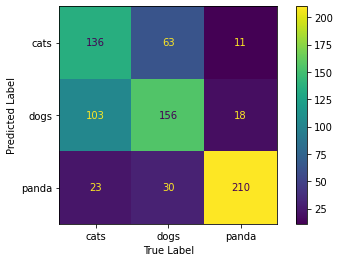

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_test": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()

14-10-2022 18:59:13 Test Evaluation metrics
14-10-2022 18:59:13 Test Accuracy: 0.6693333333333333
14-10-2022 18:59:13 Test Precision: 0.6676583190783189
14-10-2022 18:59:13 Test Recall: 0.6693333333333333
14-10-2022 18:59:13 Test F1: 0.6648520369340023


In [ ]:
run.finish()